## Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


In [25]:
df = pd.read_csv("data/creditcard.csv")
df[['Time', 'V1', 'V28', 'Amount','Class']].head()

,Time,V1,V28,Amount,Class
0,0.0,-1.359807,-0.021053,149.62,0
1,0.0,1.191857,0.014724,2.69,0
2,1.0,-1.358354,-0.059752,378.66,0
3,1.0,-0.966272,0.061458,123.50,0
4,2.0,-1.158233,0.215153,69.99,0


The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [26]:
df[['Time', 'V1', 'V28', 'Amount','Class']].describe()

,Time,V1,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,3.384781e+01,25691.160000,1.000000


Number of fraud instances: 492
Number of not fraud instances: 284,315


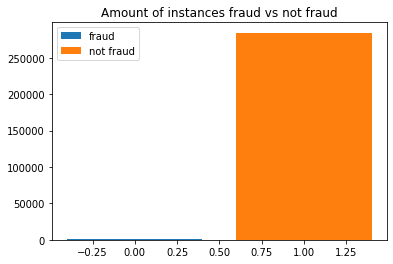

In [27]:
# Show class imbalance
fraud = df[df.Class == 1]["Class"].count()
not_fraud = df[df.Class == 0]["Class"].count()
print(f"Number of fraud instances: {fraud}")
print(f"Number of not fraud instances: {not_fraud:,}")

plt.title("Amount of instances fraud vs not fraud")
plt.bar(0, height=fraud, label="fraud")
plt.bar(1, height=not_fraud, label="not fraud")
plt.legend()
plt.show()

In [28]:
print(f"Total amount of fraud: {df[df['Class'] == 1]['Amount'].sum():,}")
print(f"Total amount in non fraudulent transactions: {df[df['Class'] == 0]['Amount'].sum():,}")


Total amount of fraud: 60,127.97
Total amount in non fraudulent transactions: 25,102,462.04


In [29]:
# Check if there are null values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [30]:
from sklearn.preprocessing import RobustScaler

# Scale Time and Amount columns
scaler = RobustScaler()
sub_df = df[["Time", "Amount"]]
df = df.drop(columns=["Time", "Amount"])
sub_df = pd.DataFrame(scaler.fit_transform(sub_df), columns=sub_df.columns)
df = pd.concat([df, sub_df], axis=1)


In [31]:
from sklearn.model_selection import train_test_split

labels = df.pop("Class")

# Split train and test set keeping negative/positive class ratio
x_train, x_test, y_train, y_test = train_test_split(
    df, labels, test_size=0.33, random_state=42, stratify=labels
)
y_train.value_counts(), y_test.value_counts()


(0    190490
 1       330
 Name: Class, dtype: int64,
 0    93825
 1      162
 Name: Class, dtype: int64)

In [32]:
class_weight_value = float(y_train.value_counts()[0]/y_train.value_counts()[1])
print(f"Class weight single value (float): {class_weight_value:.2f}")

from sklearn.utils import class_weight
sample_weight_vector = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print(f"Class weight vector length: {len(sample_weight_vector):,}")

Class weight single value (float): 577.24
Class weight vector length: 190,820


In [33]:
from xgboost import XGBClassifier

# Normal XGB
clf = XGBClassifier(seed=42, use_label_encoder=False, eval_metric="error")
clf.fit(x_train, y_train)

# Pass sample weight vector to fit method
clf2 = XGBClassifier(seed=42, use_label_encoder=False, eval_metric="error")
clf2.fit(x_train, y_train, sample_weight=sample_weight_vector)

# Pass class weight value as global config
clf3 = XGBClassifier(
    scale_pos_weight=class_weight_value,
    seed=42,
    use_label_encoder=False,
    eval_metric="error",
)
clf3.fit(x_train, y_train)

print("Normal XGB")
print(classification_report(y_pred=clf.predict(x_test), y_true=y_test))
print("Pass class weight to fit method")
print(classification_report(y_pred=clf2.predict(x_test), y_true=y_test))
print("Pass class weight as global config")
print(classification_report(y_pred=clf3.predict(x_test), y_true=y_test))


Normal XGB
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.96      0.78      0.86       162

    accuracy                           1.00     93987
   macro avg       0.98      0.89      0.93     93987
weighted avg       1.00      1.00      1.00     93987

Pass class weight to fit method
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.91      0.80      0.85       162

    accuracy                           1.00     93987
   macro avg       0.95      0.90      0.93     93987
weighted avg       1.00      1.00      1.00     93987

Pass class weight as global config
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.91      0.78      0.84       162

    accuracy                           1.00     93987
   macro avg       0.95      0.89      0.92     93

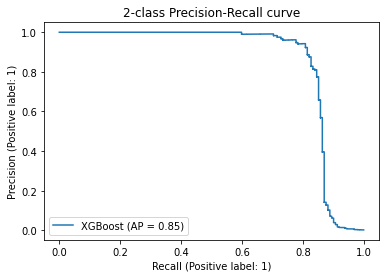

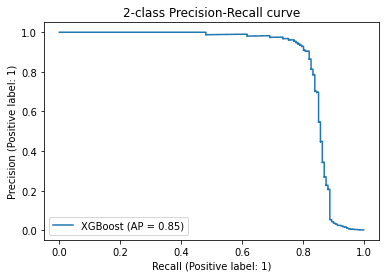

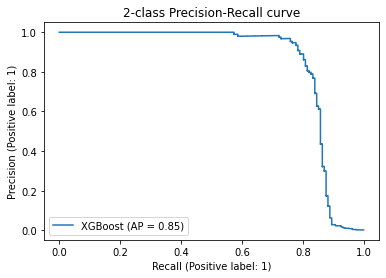

In [15]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    clf, x_test, y_test, name="XGBoost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_estimator(
    clf2, x_test, y_test, name="XGBoost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_estimator(
    clf3, x_test, y_test, name="XGBoost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")



In [12]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


Weight for class 0: 0.50
Weight for class 1: 289.44
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets


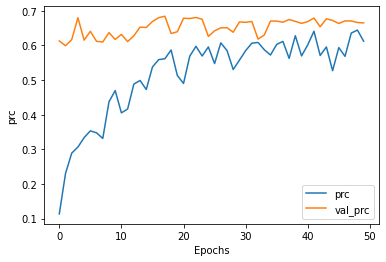

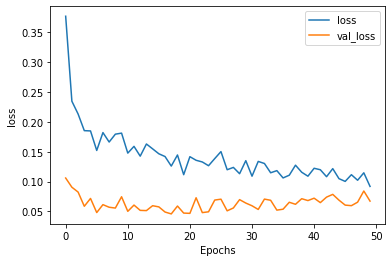

In [13]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = keras.Sequential(
    [
        keras.layers.Input(shape=len(x_train.iloc[0])),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/nn_ckp",
    monitor="val_prc",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
)


LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 50

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=[keras.metrics.AUC(name="prc", curve="PR"), keras.metrics.AUC(name="auc")],
)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(labels)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight_dict = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))


history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    validation_batch_size=BATCH_SIZE * 2,
    epochs=EPOCHS,
    verbose=0,
    class_weight=class_weight_dict,
    callbacks=[checkpoint],
)

# Plot training loss and prc curves
plot_graphs(history, "prc")
plot_graphs(history, "loss")


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     93825
           1       0.19      0.86      0.31       162

    accuracy                           0.99     93987
   macro avg       0.59      0.93      0.65     93987
weighted avg       1.00      0.99      1.00     93987

loss :  0.04588225856423378
prc :  0.6842731833457947
auc :  0.9799404144287109


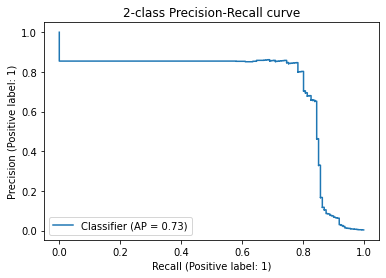

In [18]:
best_model = keras.models.load_model("models/nn_ckp")
predictions = [0 if x < 0.5 else 1 for x in best_model.predict(x_test)]
print(classification_report(y_true=y_test, y_pred=predictions))

results = best_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(best_model.metrics_names, results):
  print(name, ': ', value)

display = PrecisionRecallDisplay.from_predictions(
    y_test,
    best_model.predict(x_test),
)
_ = display.ax_.set_title("2-class Precision-Recall curve")